# 나만의 이미지로 Training Data를 만들기 위해서는

### 1. 먼저 dog_image/train 과 같은 임의의 이름을 가지는 루트 디렉토리를 만든 다음, 이러한 루트 디렉토리의 하위 디렉토리로서, 우리가 분류하고자 하는 이미지의 정답을 나타내는 디렉토리, 즉 chihuahua, jindo_dog, shepherd 같은 디렉토리를 생성하고
 
### 2. 이러한 이미지 정답을 나타내는 각 디렉토리(chihuahua, jindo_dog, shepherd)안에 직접 찍은 사진이나 인터넷에서 다운받은 파일을 최소 100개 이상 저장해 놓으면,

### 3. ImageDataGenerator.flow_from_directory()함수를 이용해서 데이터를 읽어 들일 수 있음

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
import os
import glob
import shutil

root_dir = '/Users/민동률/DL/data/image_classification'

ratio = 0.1 # train : test = 90 : 10

src_root_dir = os.path.join(root_dir, 'train/')
dst_root_dir = os.path.join(root_dir, 'test/')

label_name_list = os.listdir(src_root_dir)

for label_name in label_name_list: # test 디렉터리에 label 디렉터리 생성
    dst_label_name_dir = dst_root_dir + label_name
    
    if not os.path.exists(dst_label_name_dir):
        os.mkdir(dst_label_name_dir)

for label_name in label_name_list: # 파일 move src dir -> dst dir
    train_image_file_list = glob.glob(src_root_dir+label_name+'/*')
    split_num = int(ratio*len(train_image_file_list))
    test_image_file_list = train_image_file_list[0:split_num]
    
    for image_file in test_image_file_list:
        shutil.move(image_file, dst_root_dir+label_name) # move

## 데이터 불러오기(test 디렉토리 파일 -> test_image_file 디렉터리로 복사)

In [19]:
src_root_dir = os.path.join(root_dir, 'test/')
dst_root_dir = os.path.join(root_dir, 'test_image_files/')

label_name_list = os.listdir(src_root_dir)

for label_name in label_name_list: # 파일 copy src dir -> dst dir
    image_file_list = glob.glob(src_root_dir+label_name+'/*')
    print('total [%s] image file nums -> [%s]' % (label_name, len(image_file_list)))
    
    copy_nums = 0
    
    for image_file in image_file_list:
        shutil.copy(image_file, dst_root_dir) # copy
        copy_num = copy_nums+1
        
    print('total copy nums -> ', copy_nums)

total [chaewon] image file nums -> [10]
total copy nums ->  0
total [yena] image file nums -> [10]
total copy nums ->  0
total [yuri] image file nums -> [10]
total copy nums ->  0


## ImageDataGenerator 정의

In [20]:
img_w, img_h = 224, 224

train_dir = os.path.join(root_dir, 'train/')
val_dir = os.path.join(root_dir, 'train/')
test_dir = os.path.join(root_dir, 'test/')

In [21]:
train_dategen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, validation_split=0.15) 
# validation_split=0.15 : train데이터로부터 15%비율로 validation data 생성
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)

In [23]:
train_generator = train_dategen.flow_from_directory(train_dir, batch_size = 16, color_mode='rgb',
                                                    class_mode = 'sparse', subset='training',
                                                    target_size=(img_w, img_h))

val_generator = val_datagen.flow_from_directory(val_dir, batch_size = 16, color_mode='rgb',
                                                class_mode = 'sparse', subset='validation',
                                                target_size=(img_w, img_h))

Found 233 images belonging to 3 classes.
Found 39 images belonging to 3 classes.


In [24]:
print(train_generator.class_indices)

{'chaewon': 0, 'yena': 1, 'yuri': 2}


## 모델 구축(Pre-trained MobileNet + User-Defined Classifier)

In [25]:
base_model = MobileNet(weights='imagenet', include_top = False, input_shape=(img_w,img_h,3))

17225924/17225924 [==============================] - 1s 0us/step


In [26]:
model = Sequential()

model.add(base_model)

model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax')) # 분류가 3개이기에 출력층 노드 3개

In [27]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(2e-5), metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 32)                1605664   
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 4,834,627
Trainable params: 4,812,739
Non-trainable params: 21,888
_________________________________________

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

earlystopping = EarlyStopping(monitor='val_loss', patience=5)

hist = model.fit(train_generator, validation_data=val_generator, epochs=50, callbacks=[earlystopping])

Epoch 1/50
15/15 [==============================] - 86s 3s/step - loss: 1.7588 - accuracy: 0.3948 - val_loss: 1.3602 - val_accuracy: 0.3077
Epoch 2/50
15/15 [==============================] - 40s 3s/step - loss: 1.3148 - accuracy: 0.3820 - val_loss: 1.1427 - val_accuracy: 0.4615
Epoch 3/50
15/15 [==============================] - 40s 3s/step - loss: 1.1860 - accuracy: 0.4464 - val_loss: 1.1089 - val_accuracy: 0.4359
Epoch 4/50
15/15 [==============================] - 40s 3s/step - loss: 1.0635 - accuracy: 0.4721 - val_loss: 1.1221 - val_accuracy: 0.4359
Epoch 5/50
15/15 [==============================] - 41s 3s/step - loss: 1.0555 - accuracy: 0.4464 - val_loss: 1.1291 - val_accuracy: 0.4103
Epoch 6/50
15/15 [==============================] - 41s 3s/step - loss: 1.0542 - accuracy: 0.4635 - val_loss: 1.1172 - val_accuracy: 0.3846
Epoch 7/50
15/15 [==============================] - 38s 2s/step - loss: 1.0396 - accuracy: 0.4421 - val_loss: 1.1417 - val_accuracy: 0.2821
Epoch 8/50
15/15 [==

## 손실 및 정확도

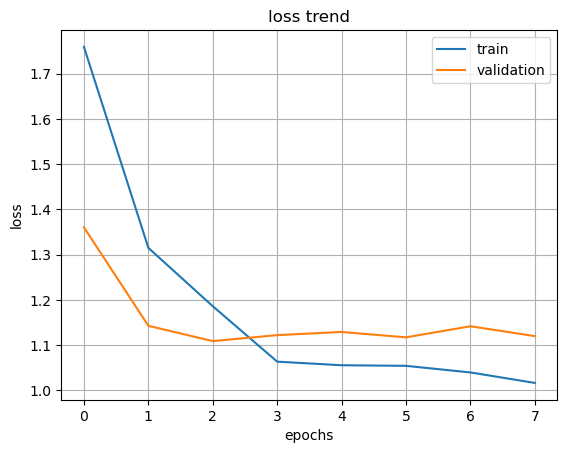

In [30]:
import matplotlib.pyplot as plt

plt.title('loss trend')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.legend(loc='best')
plt.show()

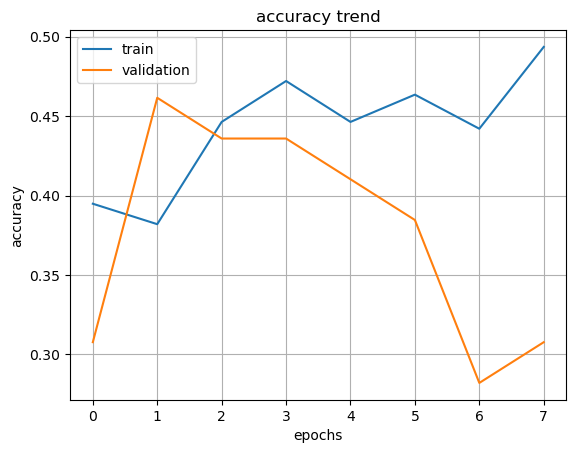

In [31]:
plt.title('accuracy trend')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.legend(loc='best')
plt.show()

## 16개 테스트 이미지 파일 생성

In [138]:
import random
import os
import numpy as np
import cv2
import glob

label_dict = {'chaewon': 0, 'yena': 1, 'yuri': 2}

test_image_files_list = glob.glob('/Users/test_image_files/*.jpg')

random.shuffle(test_image_files_list)

test_num = 16
test_image_files = test_image_files_list[:test_num]

label_list = []

for i in range(len(test_image_files)):
    label = test_image_files[i].split('\\')[-1].split('.')[0].strip()
    
    label_list.append(label_dict[label])
    
src_img_list = []
for i in range(len(test_image_files)):

    src_img = cv2.imread(test_image_files[i], cv2.IMREAD_COLOR) # 경로에 한글이 있으면 안된다
    src_img = cv2.resize(src_img, dsize=(img_w, img_h))
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
    src_img = src_img / 255.0
    
    src_img_list.append(src_img)
    
# 4차원 텐서 변환
src_img_array = np.array(src_img_list)
label_array = np.array(label_list)

In [139]:
pred = model.predict(src_img_array)
print(pred.shape)

1/1 [==============================] - 1s 578ms/step
(16, 3)


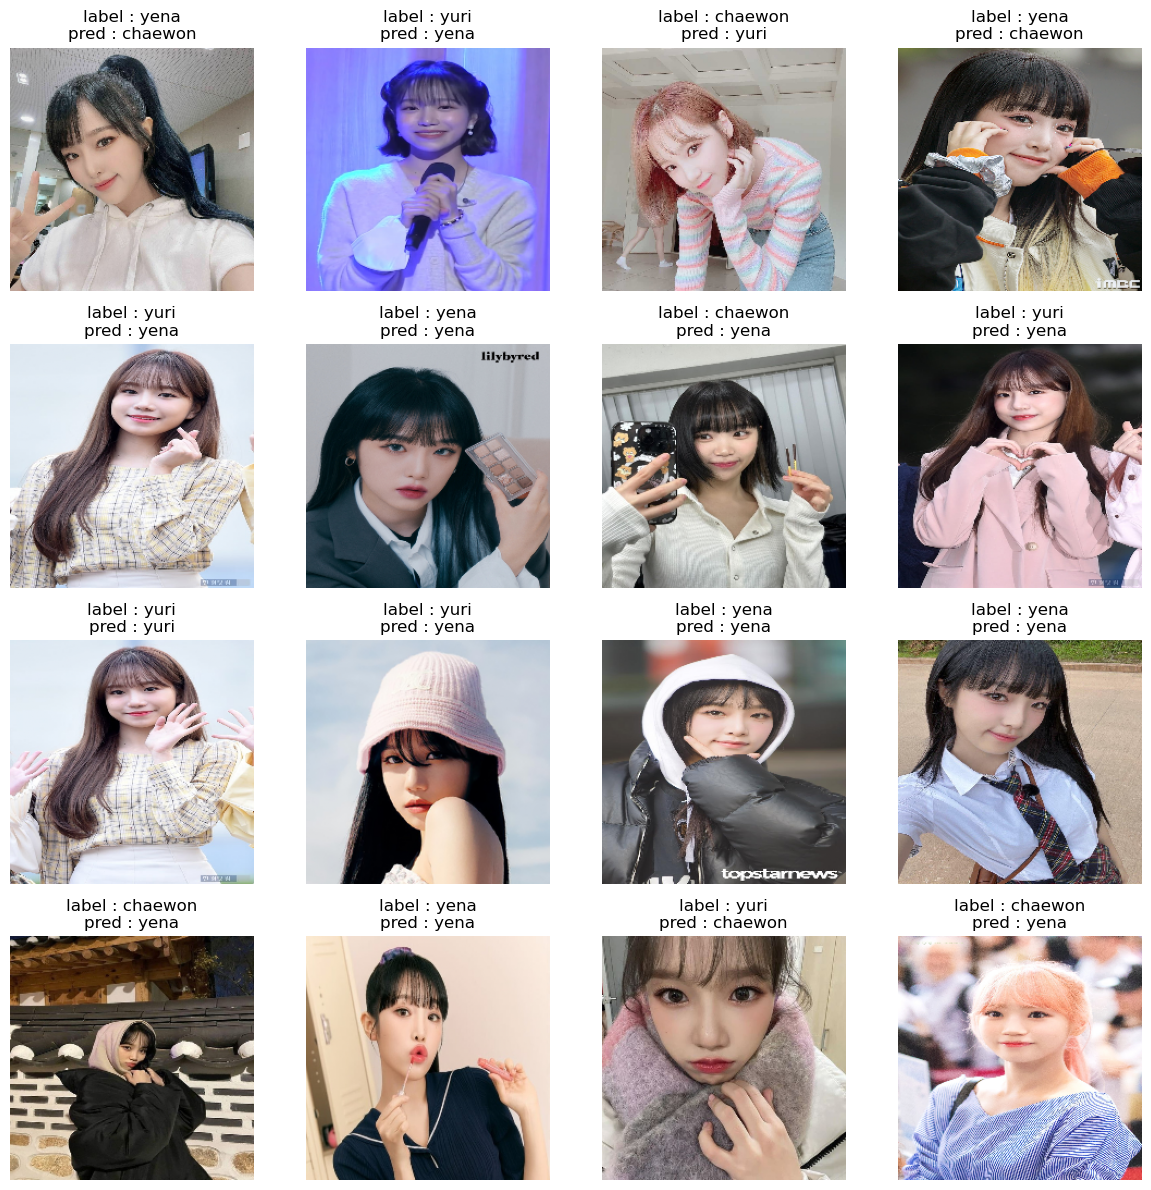

In [140]:
import matplotlib.pyplot as plt

class_names = ['chaewon','yena','yuri']

plt.figure(figsize=(12, 12))
for pos in range(len(pred)):
    
    plt.subplot(4, 4, pos+1) # -> 4행 4열 형태로 이미지 출력
    plt.axis('off')
    
    label_str = class_names[label_array[pos]]
    pred_str = class_names[np.argmax(pred[pos])] # softmax 출력이므로 argmax 통해서 인덱스 추출
    
    plt.title('label : ' + label_str + '\npred : ' + pred_str)
    
    plt.imshow(src_img_array[pos])
    
plt.tight_layout()
plt.show()